In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
import random
import seaborn as sns
import datetime
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 6.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [29]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
    df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
    df_data = df_data[ ["Open", "High", "Low", "Close", "Volume"] ]
    df_data['previous_Close'] = df_data['Close'].shift(1)
    df_data['daily_return'] = (df_data['Close']-df_data['previous_Close'])/df_data['previous_Close']
    df_data['overnight_return'] = (df_data['Open']-df_data['previous_Close'])/df_data['previous_Close']
    MA1, MA2 = 5, 20
    df_data['MA1'] = df_data['Close'].rolling(MA1).mean()
    df_data['MA2'] = df_data['Close'].rolling(MA2).mean()
    return df_data

def merge_stocks(df_data1, df_data2):
    data = []
    i = 0
    while i<len(df_data1):
        target_time = df_data1.index[i]

        j = 0
        while j<len(df_data2):
            ref_time = df_data2.index[j]
            if ref_time>=target_time:
                break
            j += 1
        ref_time = df_data2.index[j-1]
        if ref_time<target_time:
            it1 = df_data1.iloc[i]   
            open1, high1, low1, close1 = it1['Open'], it1['High'], it1['Low'], it1['Close']
            daily_return1 = it1['daily_return']
            volume1 = it1['Volume']
            target_MA1, target_MA2 = it1['MA1'], it1['MA2']
            it2 = df_data2.iloc[j-1]
            open2, high2, low2, close2 = it2['Open'], it2['High'], it2['Low'], it2['Close']
            daily_return2 = it2['daily_return']
            volume2 = it2['Volume']
            ref_MA1, ref_MA2 = it2['MA1'], it2['MA2']

            tmp_list = [ target_time, open1, high1, low1, close1, ref_time, open2, high2, low2, close2 ]
            data.append( tmp_list )
            #print( target_time, ref_time )
        i += 1
    col_names = ['target_time', 'target_open', 'target_high', 'target_low', 'target_close',
                'ref_time', 'ref_open', 'ref_high', 'ref_low', 'ref_close']
    df = pd.DataFrame(data, columns = col_names)
    return df

def LR(train_data, label_name, min_num=20):
    x = train_data["ref_"+label_name]
    y = train_data["target_"+label_name]
    if len(x)<min_num:
        return 1, 0, 0
    k, b, R, p, std_err = stats.linregress(list(x), list(y)) # R*R -> R2
    #print( '\tlinear model: y = ', round(k, 4), '* x + ', round(b, 4), "\t R2:", round(R*R, 4), "\t std error:", round(std_err, 3) )
    return k, b, R*R

def daily_models(merged_data, label_name, min_num):
    data = []
    k_list, b_list, R2_list = [], [], []
    i = 0
    while i<len(merged_data):
        train_data = merged_data.iloc[ max(0, i-100):i ].copy()
        k, b, R2 = LR(train_data, label_name, min_num)
        k_list.append( k )
        b_list.append( b )
        R2_list.append( R2 )
        if len(train_data)>0:            
            it = merged_data.iloc[i]
            target_time = it['target_time']
            target_point = it['target_'+label_name]
            ref_time = it['ref_time']
            ref_point = it['ref_'+label_name]
            train_data_it1, train_data_it2 = train_data.iloc[0], train_data.iloc[-1]
            target_from_time,target_to_time = train_data_it1['target_time'], train_data_it2['target_time']
            ref_from_time,ref_to_time = train_data_it1['ref_time'], train_data_it2['ref_time']
            #print( target_time, "\t", target_time1, ref_time1, "\t", target_time2, ref_time2 )
            data.append( [target_time, target_point, ref_time, ref_point, target_from_time, target_to_time, ref_from_time, ref_to_time, k, b, R2] )
        i += 1
    #
    col_names = ['target_time', 'target_point', 'ref_time', 'ref_point', 'target_from_time', 'target_to_time', 'ref_from_time', 'ref_to_time',
                'k_'+label_name, 'b_'+label_name, 'R2'+label_name]
    df = pd.DataFrame(data, columns = col_names)
    return df[min_num:]

def search_by_index(df_data1, target_time):
  i = 0
  while i<len(df_data1):
    current_time = df_data1.index[i]
    if target_time==current_time:
      return i
    i += 1
  return -1

def possible_returns(buy_df, df_data1, hold_days):
  hold_data1 = []
  hold_data2 = []
  Len = 5 + hold_days*3
  i = 0
  while i<len(buy_df):
    it1 = buy_df.iloc[i]
    target_time = it1['target_time']
    buy_price = it1['buy_price']
    j = search_by_index(df_data1, target_time)
    it2 = df_data1.iloc[j]
    hold_time = df_data1.index[j]
    assert target_time == hold_time
    hold_info = [ target_time, round(buy_price,1) ]
    hold_info.append( hold_time )
    hold_info.append( round(it2['Low'],1) )
    hold_info.append( round(it2['Close'],1) )
    j = j + 1
    holding_period = min(len(df_data1), j+hold_days)
    while j<holding_period:
      it2 = df_data1.iloc[j]
      hold_time = df_data1.index[j]
      hold_info.append( hold_time )
      hold_info.append( round(it2['Low'],1) )
      hold_info.append( round(it2['Close'],1) )
      j += 1
    if len(hold_info)==Len:
      hold_data1.append( hold_info )
    else:
      hold_data2.append( hold_info )
    i += 1
  col_names = ["buy_time", "buy_price"]
  for day in range(hold_days+1):
    st = "sell_"+str(day+1)
    col_names.append( st )
    col_names.append( st+"_low" )
    col_names.append( st+"_high" )
  df = pd.DataFrame(hold_data1, columns = col_names)
  return df, hold_data2

def row_to_list(hold_df, i):
  it = hold_df.iloc[i]
  buy_time, buy_price = it['buy_time'], it['buy_price']
  data_list = list(it)
  floor_list, ceiling_list = [], []
  num = 2
  while num<len(data_list):
    sell_time = data_list[num]
    num += 1
    sell_low = data_list[num]
    num += 1
    sell_high = data_list[num]
    num += 1
    floor_list.append( sell_low ) # round(sell_low/buy_price*100, 2)
    ceiling_list.append( sell_high ) # round(sell_high/buy_price*100, 2)
  return floor_list, ceiling_list, buy_time, buy_price

def call_margin1(floor_list, ceiling_list, buy_time, buy_price, loss_limit):
  flag = False
  new_buy_price = round(buy_price*(1+loss_limit*0.01/2), 1)
  new_floor_list, new_ceiling_list = [], []
  new_buy_day = 0
  assert len(ceiling_list) == len(floor_list)
  L = len(ceiling_list)
  for i in range(L):
    low = floor_list[i]
    high = ceiling_list[i]
    if flag:
      new_floor_list.append( low )
      new_ceiling_list.append( high )
    loss = (low-buy_price)/buy_price*100
    if not flag and loss<loss_limit:
      flag = True
      new_buy_day = i+1
  return new_floor_list, new_ceiling_list, new_buy_price, new_buy_day, buy_time

def call_margin2(floor_list, ceiling_list, buy_time, buy_price, loss_limit1, loss_limit2):
  
  return 


def gain_loss_balance(floor_list, ceiling_list, buy_time, buy_price, gain_limit, loss_limit):
  assert len(ceiling_list) == len(floor_list)
  L = len(ceiling_list)
  r1, r2 = 0, 0
  i = 0
  while i<L:
    low = floor_list[i]
    high = ceiling_list[i]
    r1 = (low-buy_price)/buy_price*100
    r2 = (high-buy_price)/buy_price*100
    if r1<=loss_limit:
      return r1, r2, i
    if r2>=gain_limit:
      return r1, r2, i
    i += 1
  return r1, r2, i

In [31]:
stocks_info = [
    ('BABA', '9988.HK', '2022-11-01', 1),
    ('BIDU', '9888.HK', '2022-10-25', 1),
    ('JD', '9618.HK', '2022-10-24', 0.5 * 7.8),
    ('MPNGY', '3690.HK', '2022-10-24', 0.5 * 7.8),
    ('NTES', '9999.HK', '2022-10-26', 0.2 * 7.8),
    ('LI', '2015.HK', '2022-10-26', 0.5 * 7.8),
    ('NIO', '9866.HK', '2022-10-26', 1 * 7.8)
]

total_business_days = 0
gain_rate, loss_rate = 1.3, 9
trade_info_col = {}
for it in stocks_info[:6]:
        # get market data of target-stock & reference-stock
  reference_stock, target_stock, st, ratio = it
  st, et = "2021-01-01", "2023-02-28"
  print("time range:\t", st, "-", et)
  df_data1 = get_df_data(ticker_name=target_stock, start_time=st, end_time=et)
  print("target stock:\t", target_stock, "\t", len(df_data1))
  df_data2 = get_df_data(ticker_name=reference_stock, start_time=st, end_time=et)
  print("reference stock:\t", reference_stock, "\t", len(df_data2))
      # merge reference-stock & target-stock: target stock (datetime, open, high, low, close), 1-day previous reference stock (datetime, open, high, low, close) 
  merged_data = merge_stocks(df_data1, df_data2)
  for label_name in ['low']: # "open", "high", "low", "close"
      # daily LR modelling
    model_df = daily_models(merged_data, label_name, 100) 
      # moving average to smoothen model errors for daily models
    MA_days = 20 
    model_df['k_'+label_name+"_MA"] = model_df['k_'+label_name].rolling(MA_days).mean()
    model_df['b_'+label_name+"_MA"] = model_df['b_'+label_name].rolling(MA_days).mean()
    model_df = model_df[MA_days:]
      # recommended buy-price
    model_df['buy_price'] = (model_df['ref_point']*model_df['k_'+label_name+ '_MA']+model_df['b_'+label_name+'_MA'])*0.985
    buy_df = model_df[ model_df['buy_price']>=model_df['target_point'] ]
      # after buying, hold some period to analyse returns
    holding_days = 20
    hold_df, hold_data2 = possible_returns(buy_df[-60:], df_data1, holding_days)
    counter1, counter2, counter3 = 0, 0, 0
    for i in range(len(hold_df)):
      floor_list, ceiling_list, buy_time, buy_price = row_to_list(hold_df, i)
      rtn1, rtn2 = round(max(ceiling_list)/buy_price*100-100, 2), round(min(floor_list)/buy_price*100-100, 2)
      
      """gain_limit = 2
      loss_limit = -20
      r1, r2, hold_period = gain_loss_balance(floor_list, ceiling_list, buy_time, buy_price, gain_limit, loss_limit)
      rtn2, rtn1 = round(r1, 2), round(r2, 2)
      rtn1 = min(gain_limit, rtn1)
      rtn2 = max(loss_limit, rtn2)
      if rtn2==-8:
        rtn1 = rtn2"""
      
      #print(i, "\t", buy_time, "\t", buy_price, "\t", "day(s)\t", rtn1, "%\t", rtn2, "%")

      loss_limit = -6
      new_floor_list, new_ceiling_list, new_buy_price, new_buy_day, buy_time = call_margin1(floor_list, ceiling_list, buy_time, buy_price, loss_limit)
      if len(new_ceiling_list)>0 and rtn1<=1.5:
        new_rtn1, new_rtn2 = (max(new_ceiling_list)-new_buy_price)/new_buy_price*100, (min(new_floor_list)-new_buy_price)/new_buy_price*100
        #print("\t\t", new_buy_day, "day(s)", "\t", new_buy_price, "\t", round(new_rtn1, 2), round(new_rtn2, 2))
        rtn1, rtn2 = round(new_rtn1, 2), round(new_rtn2, 2)
        #print("\t\t", buy_time, "+", new_buy_day, "day(s)\t", buy_price, "->", new_buy_price, "\t", rtn1, "%\t", rtn2, "%")
           
      counter1 += 1
      if rtn1>=1.5:
        counter2 += 1
      else:
        counter3 += 1        
    print( counter1, "\t", counter2, "\t", round(counter2/counter1*100, 2) )
    print( counter1, "\t", counter3, "\t", round(counter3/counter1*100, 2) )
    
  print()

time range:	 2021-01-01 - 2023-02-28
[*********************100%***********************]  1 of 1 completed
target stock:	 9988.HK 	 519
[*********************100%***********************]  1 of 1 completed
reference stock:	 BABA 	 531
55 	 48 	 87.27
55 	 7 	 12.73

time range:	 2021-01-01 - 2023-02-28
[*********************100%***********************]  1 of 1 completed
target stock:	 9888.HK 	 465
[*********************100%***********************]  1 of 1 completed
reference stock:	 BIDU 	 531
54 	 49 	 90.74
54 	 5 	 9.26

time range:	 2021-01-01 - 2023-02-28
[*********************100%***********************]  1 of 1 completed
target stock:	 9618.HK 	 519
[*********************100%***********************]  1 of 1 completed
reference stock:	 JD 	 531
54 	 47 	 87.04
54 	 7 	 12.96

time range:	 2021-01-01 - 2023-02-28
[*********************100%***********************]  1 of 1 completed
target stock:	 3690.HK 	 519
[*********************100%***********************]  1 of 1 completed
refe

2022-07-12 00:00:00 	 142.5 	 52.7 %	 25.1 %


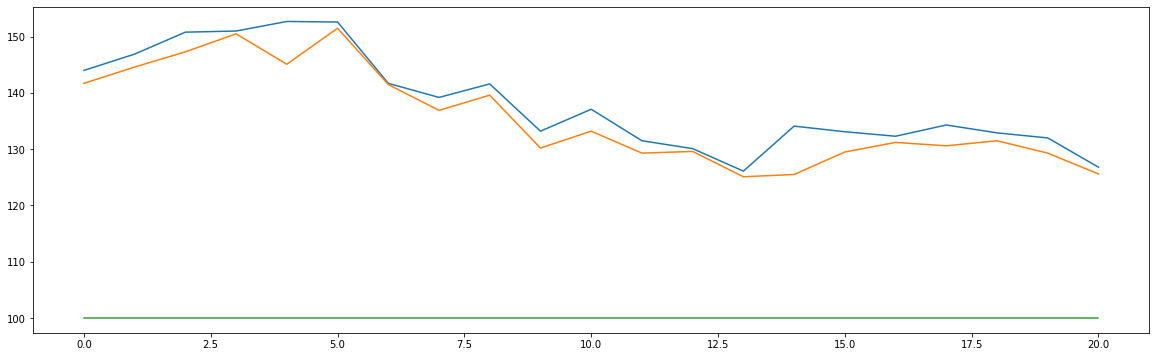

In [32]:
floor_list, ceiling_list, buy_time, buy_price = row_to_list(hold_df, 6)
rtn1, rtn2 = round(max(ceiling_list)-100, 2), round(min(floor_list)-100, 2)
print(buy_time, "\t", buy_price, "\t", rtn1, "%\t", rtn2, "%")
plt.figure(figsize=(20, 6))
plt.plot(list(range(len(ceiling_list))), ceiling_list, label="holding trend 1")  # Plot the chart
plt.plot(list(range(len(floor_list))), floor_list, label="holding trend 2")  # Plot the chart
plt.plot(list(range(len(floor_list))), [100]*len(floor_list), label="holding level")  # Plot the chart
plt.show()  # display